In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from datetime import datetime
import time 
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import scipy.stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import optuna
#from xgboost import XGBRegressor
#from pycaret.regression import setup, compare_models, models

## Load the data

In [29]:
df_train = pd.read_csv('Ames_Housing_Price_Data.csv',index_col=0)

## Examine the data

In [30]:
df_train.head(10)

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
1   909176150        856     126000          30       RL          NaN   
2   905476230       1049     139500         120       RL         42.0   
3   911128020       1001     124900          30  C (all)         60.0   
4   535377150       1039     114000          70       RL         80.0   
5   534177230       1665     227000          60       RL         70.0   
6   908128060       1922     198500          85       RL         64.0   
7   902135020        936      93000          20       RM         60.0   
8   528228540       1246     187687          20       RL         53.0   
9   923426010        889     137500          20       RL         74.0   
10  908186050       1072     140000         180       RM         35.0   

    LotArea Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
1      7890   Pave   NaN      Reg         Lvl    AllPub    Corner       Gtl   
2      4235   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
3      6060   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
4      8146   Pave   NaN      Reg         Lvl    AllPub    Corner       Gtl   
5      8400   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
6      7301   Pave   NaN      Reg         Lvl    AllPub    Corner       Gtl   
7      6000   Pave  Pave      Reg         Bnk    AllPub    Inside       Mod   
8      3710   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
9     12395   Pave   NaN      Reg         Lvl    AllPub    Corner       Gtl   
10     3675   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   

   Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  \
1         SWISU       Norm       Norm     1Fam     1Story            6   
2       Edwards       Norm       Norm   TwnhsE     1Story            5   
3        IDOTRR       Norm       Norm     1Fam     1Story            5   
4       OldTown       Norm       Norm     1Fam     2Story            4   
5        NWAmes       Norm       Norm     1Fam     2Story            8   
6       Edwards       Norm       Norm     1Fam     SFoyer            7   
7       OldTown       Norm       Norm   2fmCon     1Story            4   
8       Blmngtn       Norm       Norm     1Fam     1Story            7   
9       Mitchel       Norm       Norm     1Fam     1Story            5   
10      Edwards       Norm       Norm   TwnhsE     SFoyer            6   

    OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st  \
1             6       1939          1950     Gable  CompShg     Wd Sdng   
2             5       1984          1984     Gable  CompShg     HdBoard   
3             9       1930          2007       Hip  CompShg     MetalSd   
4             8       1900          2003     Gable  CompShg     MetalSd   
5             6       2001          2001     Gable  CompShg     VinylSd   
6             5       2003          2003     Gable  CompShg     HdBoard   
7             4       1953          1953     Gable  CompShg     MetalSd   
8             5       2007          2008     Gable  CompShg     WdShing   
9             6       1984          1984     Gable  CompShg     HdBoard   
10            5       2005          2005     Gable  CompShg     VinylSd   

   Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
1      Wd Sdng       None         0.0        TA        TA     CBlock       TA   
2      HdBoard    BrkFace       149.0        Gd        TA     CBlock       Gd   
3      MetalSd       None         0.0        Gd        TA     BrkTil       TA   
4      MetalSd       None         0.0        Gd        Gd     BrkTil       Fa   
5      VinylSd       None         0.0        Gd        TA      PConc       Gd   
6      HdBoard    BrkFace       500.0        Gd        TA       Slab      NaN   
7      MetalSd       None         0.0        Fa        TA     CBlock       Fa   
8      Wd Shng    BrkFace        20.0        Gd

In [31]:
#Check the number of NAs in each column
df_train.isna().sum()

PID                 0
GrLivArea           0
SalePrice           0
MSSubClass          0
MSZoning            0
LotFrontage       462
LotArea             0
Street              0
Alley            2412
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType         14
MasVnrArea         14
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           69
BsmtCond           69
BsmtExposure       71
BsmtFinType1       69
BsmtFinSF1          1
BsmtFinType2       70
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF  

# Data Cleaning/Preprocessing

In [32]:
target=df_train.SalePrice

In [33]:
test_ids=df_train.PID

In [34]:
df_train=df_train.drop(columns=['PID', 'SalePrice'])

In [35]:
df_train_copy=df_train.copy()

### Use .info() to see length and dtypes

In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2580 entries, 1 to 763
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2580 non-null   int64  
 1   MSSubClass     2580 non-null   int64  
 2   MSZoning       2580 non-null   object 
 3   LotFrontage    2118 non-null   float64
 4   LotArea        2580 non-null   int64  
 5   Street         2580 non-null   object 
 6   Alley          168 non-null    object 
 7   LotShape       2580 non-null   object 
 8   LandContour    2580 non-null   object 
 9   Utilities      2580 non-null   object 
 10  LotConfig      2580 non-null   object 
 11  LandSlope      2580 non-null   object 
 12  Neighborhood   2580 non-null   object 
 13  Condition1     2580 non-null   object 
 14  Condition2     2580 non-null   object 
 15  BldgType       2580 non-null   object 
 16  HouseStyle     2580 non-null   object 
 17  OverallQual    2580 non-null   int64  
 18  OverallCo

## Identify numerical and categorical variables

In [37]:
cols_list=list(df_train.columns)
cols_list

['GrLivArea',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'Enc

In [38]:
#MSSUBClass is actually a categoical data coluumn per the data descrpition text file
df_train.MSSubClass=df_train.MSSubClass.astype(str)

In [39]:
#looking at columns that consist of numberic values only
df_train._get_numeric_data()

GrLivArea  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
1           856          NaN     7890            6            6       1939   
2          1049         42.0     4235            5            5       1984   
3          1001         60.0     6060            5            9       1930   
4          1039         80.0     8146            4            8       1900   
5          1665         70.0     8400            8            6       2001   
6          1922         64.0     7301            7            5       2003   
7           936         60.0     6000            4            4       1953   
8          1246         53.0     3710            7            5       2007   
9           889         74.0    12395            5            6       1984   
10         1072         35.0     3675            6            5       2005   
11         1342         48.0     6240            8            5       2006   
12         1274         63.0    10475            5            5       1991   
13          861         62.0     7404            4            6       1920   
14         1394          NaN     9500            6            5       1963   
15         1536         70.0     9135            7            5       2002   
16         1680         50.0     8480            6            5       1993   
17         1274         68.0     8814            7            5       2005   
18          864         45.0     8248            3            3       1914   
19         1610          NaN    10603            6            7       1977   
20         1091         62.0     7706            6            5       1993   
21         1486         65.0     7441            7            5       2006   
22          789         50.0     6000            5            5       1948   
23         1092         21.0     1477            6            9       1970   
24         2640         65.0    11700            7            7       1880   
25         1092         21.0     1680            5            5       1971   
26         1458         58.0    13204            7            5       2006   
27         1466         73.0     8925            8            5       2007   
28         1573          NaN     2117            6            5       2000   
29         2090          NaN    10382            7            6       1973   
30         2046        105.0    15431           10            5       2005   
31          886         50.0     5784            5            8       1938   
32         1258         64.0     7697            7            6       2007   
33         1324        100.0    18494            6            5       2005   
34         1848         64.0    13053            6            7       1923   
35         1269         70.0     7931            5            6       1960   
36         1346         88.0    11896            7            5       2008   
37         1749         68.0     9272            7            5       1999   
38          492         52.0     7830            3            5       1921   
39         2030          NaN    12046            6            6       1976   
40          988         65.0     7150            5            6       1966   
41         2172          NaN    11000            9            5       2000   
42         1080         71.0     9187            6            5       1983   
43         1312         76.0    11355            7            7       1958   
44          925          NaN     8638            5            6       1963   
45         1534         60.0    10800            5            9       1895   
46         2376        101.0    14215            8            5       2005   
47         1959         59.0    11796            7            5       2004   
48         1716         60.0    11409            5            4       1949   
49          936         56.0     4485            5            7       1920   
50         1230         60.0    10440            5            6       1910   
51         2592         60.0

# Remove features based on correlation to avoid multicollinearity 

GrLivArea  LotFrontage   LotArea  OverallQual  OverallCond  \
GrLivArea       1.000000     0.345448  0.260322     0.559897    -0.105670   
LotFrontage     0.345448     1.000000  0.463720     0.179656    -0.054048   
LotArea         0.260322     0.463720  1.000000     0.080607    -0.032693   
OverallQual     0.559897     0.179656  0.080607     1.000000    -0.095927   
OverallCond    -0.105670    -0.054048 -0.032693    -0.095927     1.000000   
YearBuilt       0.228400     0.099602  0.012397     0.574400    -0.397274   
YearRemodAdd    0.306035     0.063548  0.010293     0.546297     0.065100   
MasVnrArea      0.387206     0.202139  0.103416     0.405763    -0.143986   
BsmtFinSF1      0.164899     0.177304  0.163468     0.273919    -0.064347   
BsmtFinSF2     -0.021056     0.055247  0.082339    -0.030383     0.029990   
BsmtUnfSF       0.245545     0.104167  0.019738     0.255698    -0.123998   
TotalBsmtSF     0.409814     0.307885  0.222042     0.528069    -0.179473   
1stFlrSF        0.539135     0.437324  0.313086     0.454481    -0.156592   
2ndFlrSF        0.665001     0.005644  0.022434     0.246885     0.015073   
LowQualFinSF    0.088931    -0.010623 -0.000334    -0.044359     0.019018   
BsmtFullBath    0.044749     0.106641  0.118788     0.173342    -0.057921   
BsmtHalfBath   -0.053401    -0.028832  0.027586    -0.050571     0.085160   
FullBath        0.643937     0.169696  0.124352     0.508255    -0.210226   
HalfBath        0.445513     0.026992  0.026727     0.271455    -0.096052   
BedroomAbvGr    0.538022     0.247952  0.140430     0.067466     0.004108   
KitchenAbvGr    0.129797     0.018644 -0.014575    -0.153691    -0.075642   
TotRmsAbvGrd    0.807445     0.342825  0.204545     0.360675    -0.072482   
Fireplaces      0.457926     0.249181  0.245148     0.387777    -0.046570   
GarageYrBlt     0.266934     0.051578 -0.016526     0.558484    -0.335619   
GarageCars      0.495011     0.302285  0.175733     0.581023    -0.195780   
GarageArea      0.477152     0.337158  0.199241     0.538183    -0.168238   
WoodDeckSF      0.247716     0.123743  0.155687     0.250181     0.014161   
OpenPorchSF     0.321777     0.142809  0.084963     0.286861    -0.067437   
EnclosedPorch   0.000196     0.003480  0.017694    -0.134291     0.085910   
3SsnPorch       0.008714     0.034406  0.017721     0.014226     0.041904   
ScreenPorch     0.097835     0.083849  0.053820     0.049277     0.050417   
PoolArea        0.057935     0.086041  0.052636    -0.002484    -0.021193   
MiscVal        -0.003940     0.017859  0.040220    -0.025825     0.046015   
MoSold          0.038389     0.002164  0.010203     0.016780     0.012211   
YrSold         -0.008260    -0.002555 -0.017319     0.005668     0.017632   

               YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  \
GrLivArea       0.228400      0.306035    0.387206    0.164899   -0.021056   
LotFrontage     0.099602      0.063548    0.202139    0.177304    0.055247   
LotArea         0.012397      0.010293    0.103416    0.163468    0.082339   
OverallQual     0.574400      0.546297    0.405763    0.273919   -0.030383   
OverallCond    -0.397274      0.065100   -0.143986   -0.064347    0.029990   
YearBuilt       1.000000      0.572276    0.307228    0.303616   -0.009807   
YearRemodAdd    0.572276      1.000000    0.175371    0.156527   -0.051202   
MasVnrArea      0.307228      0.175371    1.000000    0.277336   -0.009519   
BsmtFinSF1      0.303616      0.156527    0.277336    1.000000   -0.058911   
BsmtFinSF2     -0.009807     -0.051202   -0.009519   -0.058911    1.000000   
BsmtUnfSF       0.092171      0.130649    0.080283   -0.480927   -0.242334   
TotalBsmtSF     0.400983      0.271944    0.361515    0.512642    0.110119   
1stFlrSF        0.294691      0.217709    0.362168    0.426763    0.094029   
2ndFlrSF        0.015754      0.166301    0.131230   -0.180968   -0.107159   
LowQualFinSF   -0.132086     -0.063714   -0.054146   -0.070774   -0.0044

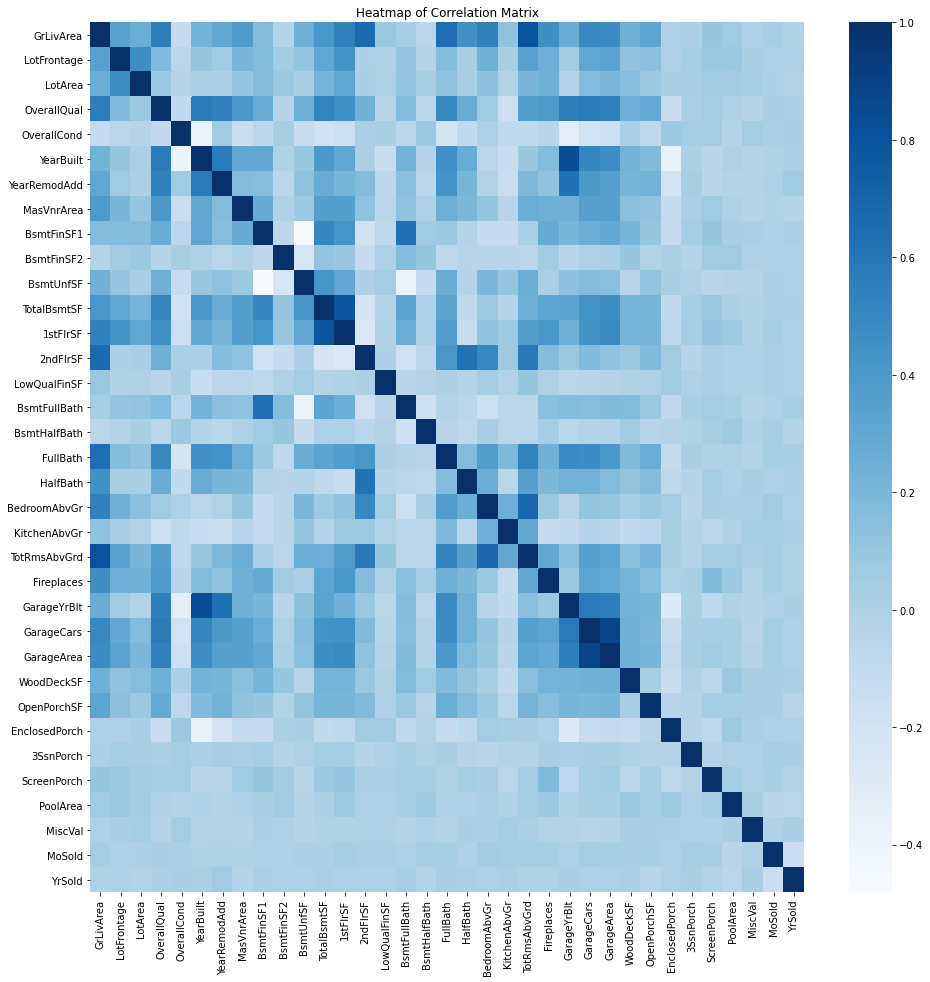

In [46]:
corr=df_train.corr()
plt.figure(figsize = (16, 16))
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values, cmap="Blues")

plt.title('Heatmap of Correlation Matrix')
corr

In [82]:
high_corr_pairs = np.where(abs(corr) > 0.7)
high_corr_pairs = [(corr.index[x], corr.columns[y]) for x, y in zip(*high_corr_pairs)
                                        if x != y and x < y]
high_corr_pairs

[('GrLivArea', 'TotRmsAbvGrd'),
 ('YearBuilt', 'GarageYrBlt'),
 ('TotalBsmtSF', '1stFlrSF'),
 ('GarageCars', 'GarageArea')]

### Per the data description, 
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

TotalBsmtSF=BsmtFinSF1+BsmtFinSF2+BsmtUnfSF

GrLivArea=1stFlrSF+2ndFlrSF+LowQualFinSF

In [98]:
#Dropping numerical columns of which have high correaltion with one another
df_train=df_train.drop(["TotRmsAbvGrd","GarageYrBlt","GarageArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","1stFlrSF","2ndFlrSF","LowQualFinSF"],axis=1)

## Data Inputation

### Categorical

In [103]:
#Show all columns with missing values
df_train.columns[df_train.isnull().any()]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')

In [104]:
#Show all categorical/object columns with missing values
df_train.select_dtypes("object").isna().sum()!=0

MSSubClass       False
MSZoning         False
Street           False
Alley             True
LotShape         False
LandContour      False
Utilities        False
LotConfig        False
LandSlope        False
Neighborhood     False
Condition1       False
Condition2       False
BldgType         False
HouseStyle       False
RoofStyle        False
RoofMatl         False
Exterior1st      False
Exterior2nd      False
MasVnrType        True
ExterQual        False
ExterCond        False
Foundation       False
BsmtQual          True
BsmtCond          True
BsmtExposure      True
BsmtFinType1      True
BsmtFinType2      True
Heating          False
HeatingQC        False
CentralAir       False
Electrical        True
KitchenQual      False
Functional       False
FireplaceQu       True
GarageType        True
GarageFinish      True
GarageQual        True
GarageCond        True
PavedDrive       False
PoolQC            True
Fence             True
MiscFeature       True
SaleType         False
SaleConditi

In [115]:
#Fill NAs in these columns with None when a missing value means something
#e.g. NA basement means no basement

for column in ["Alley",
               "BsmtQual",
               "BsmtCond",
               "BsmtExposure",
               "BsmtFinType1",
               "BsmtFinType2",
               "FireplaceQu",
               "GarageType",
               "GarageFinish",
               "GarageQual",
               "GarageCond",
               "PoolQC",
               "Fence",
               "MiscFeature"]:
    df_test[column]=df_test[column].fillna("None")

In [92]:
#Fill NAs in these columns with mode
for column in ["MasVnrType","Electrical"]:
    df_test[column]=df_test[column].fillna(df_test[column].mode()[0])

In [95]:
df_test.select_dtypes("object").isna().sum()

MSSubClass       0
MSZoning         0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinType2     0
Heating          0
HeatingQC        0
CentralAir       0
Electrical       0
KitchenQual      0
Functional       0
FireplaceQu      0
GarageType       0
GarageFinish     0
GarageQual       0
GarageCond       0
PavedDrive       0
PoolQC           0
Fence            0
MiscFeature      0
SaleType         0
SaleCondition    0
dtype: int64

## Numerical

In [111]:
df_test.select_dtypes("number").isna().sum()

GrLivArea          0
LotFrontage      462
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea        14
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
BsmtFullBath       2
BsmtHalfBath       2
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt      129
GarageCars         1
GarageArea         1
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [107]:
#Show all numeric columns with missing values
df_test.select_dtypes("number").isna().sum()!=0

GrLivArea        False
LotFrontage       True
LotArea          False
OverallQual      False
OverallCond      False
YearBuilt        False
YearRemodAdd     False
MasVnrArea        True
BsmtFinSF1        True
BsmtFinSF2        True
BsmtUnfSF         True
TotalBsmtSF       True
1stFlrSF         False
2ndFlrSF         False
LowQualFinSF     False
BsmtFullBath      True
BsmtHalfBath      True
FullBath         False
HalfBath         False
BedroomAbvGr     False
KitchenAbvGr     False
TotRmsAbvGrd     False
Fireplaces       False
GarageYrBlt       True
GarageCars        True
GarageArea        True
WoodDeckSF       False
OpenPorchSF      False
EnclosedPorch    False
3SsnPorch        False
ScreenPorch      False
PoolArea         False
MiscVal          False
MoSold           False
YrSold           False
dtype: bool

In [112]:
# Checking LotFrontage first
#Fill NAs in these columns with mean
#

for column in ["LotFrontage","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","BsmtFullBath","BsmtHalfBath","GarageYrBlt","GarageCars","GarageArea"]:
    df_test[column]=df_test[column].fillna(df_test[column].mean())

In [113]:
df_test.select_dtypes("number").isna().sum()

GrLivArea        0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageYrBlt      0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

In [544]:
num_cols=['ID','goal','pledged','backers',
          'usd pledged','usd_pledged_real','usd_goal_real',
          'duration_in_days','percent_pledged']

In [545]:
cat_cols=['name','category',
 'main_category',
 'currency',
 'deadline',
 'launched',
 'state',
 'country']

## Summarize numberical and categorical variables separately

In [558]:
df_us.describe(include=[np.number])

backers  usd_pledged_real  usd_goal_real  duration_in_days  \
count  292627.000000      2.926270e+05   2.926270e+05     292627.000000   
mean      113.078615      9.670193e+03   4.403497e+04         33.740954   
std       985.723400      9.932942e+04   1.108372e+06         68.025055   
min         0.000000      0.000000e+00   1.000000e-02          0.000000   
25%         2.000000      4.100000e+01   2.000000e+03         29.000000   
50%        14.000000      7.250000e+02   5.250000e+03         29.000000   
75%        60.000000      4.370000e+03   1.500000e+04         37.000000   
max    219382.000000      2.033899e+07   1.000000e+08      14866.000000   

       percent_pledged  
count     2.926270e+05  
mean      3.772658e+02  
std       3.013829e+04  
min       0.000000e+00  
25%       6.000000e-01  
50%       1.578000e+01  
75%       1.074000e+02  
max       1.042779e+07

In [559]:
df_us.describe(include=['O']) #The 'O' stands for objects

name        category main_category currency  \
count                     292624          292627        292627   292627   
unique                    290800             159            15        1   
top     New EP/Music Development  Product Design  Film & Video      USD   
freq                          13           16222         51922   292627   

         state country  
count   292627  292627  
unique       5       1  
top     failed      US  
freq    152061  292627

## Revisiting the distrubtions in different columns

In [560]:
df_us['category'].value_counts()

Product Design     16222
Documentary        13671
Music              11595
Tabletop Games     10691
Shorts             10348
                   ...  
Residencies           43
Letterpress           34
Chiptune              23
Literary Spaces       19
Taxidermy              8
Name: category, Length: 159, dtype: int64

In [561]:
df_us['main_category'].value_counts()

Film & Video    51922
Music           43238
Publishing      31726
Games           24636
Art             22311
Design          21690
Technology      21556
Food            19941
Fashion         16584
Comics           8910
Theater          8709
Photography      7988
Crafts           6648
Journalism       3540
Dance            3228
Name: main_category, dtype: int64

In [562]:
df_us['state'].value_counts()

failed        152061
successful    109299
canceled       28311
live            1740
suspended       1216
Name: state, dtype: int64

In [563]:
df_us['country'].value_counts()

US    292627
Name: country, dtype: int64

In [564]:
df_us['duration_in_days'].value_counts()

29       128289
59        25520
44        14587
30        10753
34         7657
          ...  
14708         1
14732         1
14749         1
14760         1
14834         1
Name: duration_in_days, Length: 98, dtype: int64

## Exploratory Data Analysis

In [565]:
df_us.shape

(292627, 13)

In [566]:
df_us.groupby('main_category').mean()

backers  usd_pledged_real  usd_goal_real  duration_in_days  \
main_category                                                                  
Art             43.028999       3306.613835   32925.693900         32.519923   
Comics         141.334119       7072.704378   22111.481514         33.252413   
Crafts          29.869886       1720.494546   10689.841682         30.326865   
Dance           45.671314       3695.297280    9345.089622         32.085812   
Design         269.816598      26732.962466   44079.063067         34.377317   
Fashion         67.794561       6079.896657   22524.952777         31.956585   
Film & Video    70.861658       6659.951323   80393.303565         35.368514   
Food            59.306504       5648.474497   36526.483657         33.071310   
Games          375.685988      24947.336634   49400.623648         31.709693   
Journalism      40.248870       2815.561096  102191.030305         33.725141   
Music           56.888061       4087.055214   15831.124693         34.960729   
Photography     40.139459       3662.672882   12742.446358         33.159990   
Publishing      56.247400       3361.632477   26743.173264         33.165605   
Technology     198.787669      25789.472505  100281.630275         34.491789   
Theater         50.315421       4293.059484   28198.256242         34.698358   

               percent_pledged  
main_category                   
Art                 284.482705  
Comics              736.199278  
Crafts              299.849722  
Dance                83.767937  
Design              215.730583  
Fashion             111.301232  
Film & Video        171.904246  
Food                 94.050394  
Games               926.028269  
Journalism           37.628180  
Music               901.011986  
Photography          61.658090  
Publishing          210.190161  
Technology          372.309389  
Theater              93.043866

In [567]:
df_us.groupby('category').mean()

backers  usd_pledged_real  usd_goal_real  duration_in_days  \
category                                                                     
3D Printing  299.968059      88990.022408   49346.154791         32.592138   
Academic      44.276699       3162.870065   70089.813916         33.792880   
Accessories   90.644433       6827.443912   14928.683049         30.253761   
Action        58.080979       4231.197740  240611.815443         34.664783   
Animals       40.962025       2187.025886   12256.075949         29.126582   
...                 ...               ...            ...               ...   
Woodworking   20.609493       1613.554466   11352.288026         29.258900   
Workshops     21.983333       1655.653667   10668.041667         32.191667   
World Music   58.402143       4592.354828   33704.216300         35.323181   
Young Adult   21.096248       1466.217553   11528.719413         31.774878   
Zines         56.316742       2542.455113   13846.443439         29.162896   

             percent_pledged  
category                      
3D Printing       211.271320  
Academic          190.749184  
Accessories       119.314139  
Action             55.574830  
Animals            68.042201  
...                      ...  
Woodworking       303.126607  
Workshops          45.641617  
World Music        68.111375  
Young Adult       597.997415  
Zines             115.016908  

[159 rows x 5 columns]

In [568]:
df_us.groupby('state').mean()

backers  usd_pledged_real  usd_goal_real  duration_in_days  \
state                                                                       
canceled     25.820670       2317.801194   76293.964894         38.528099   
failed       16.772118       1331.173917   60664.242108         34.477164   
live         77.495402       6352.720575   84039.947701         38.417816   
successful  270.177952      23212.887104    9695.670955         31.392108   
suspended   117.960526      11119.731497  242796.605263         34.654605   

            percent_pledged  
state                        
canceled         103.073911  
failed             9.247504  
live             395.825101  
successful       962.726786  
suspended        131.603517

# Feature Transformations

In [119]:
df_test.select_dtypes("number")

GrLivArea  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
1           856    68.516053     7890            6            6       1939   
2          1049    42.000000     4235            5            5       1984   
3          1001    60.000000     6060            5            9       1930   
4          1039    80.000000     8146            4            8       1900   
5          1665    70.000000     8400            8            6       2001   
6          1922    64.000000     7301            7            5       2003   
7           936    60.000000     6000            4            4       1953   
8          1246    53.000000     3710            7            5       2007   
9           889    74.000000    12395            5            6       1984   
10         1072    35.000000     3675            6            5       2005   
11         1342    48.000000     6240            8            5       2006   
12         1274    63.000000    10475            5            5       1991   
13          861    62.000000     7404            4            6       1920   
14         1394    68.516053     9500            6            5       1963   
15         1536    70.000000     9135            7            5       2002   
16         1680    50.000000     8480            6            5       1993   
17         1274    68.000000     8814            7            5       2005   
18          864    45.000000     8248            3            3       1914   
19         1610    68.516053    10603            6            7       1977   
20         1091    62.000000     7706            6            5       1993   
21         1486    65.000000     7441            7            5       2006   
22          789    50.000000     6000            5            5       1948   
23         1092    21.000000     1477            6            9       1970   
24         2640    65.000000    11700            7            7       1880   
25         1092    21.000000     1680            5            5       1971   
26         1458    58.000000    13204            7            5       2006   
27         1466    73.000000     8925            8            5       2007   
28         1573    68.516053     2117            6            5       2000   
29         2090    68.516053    10382            7            6       1973   
30         2046   105.000000    15431           10            5       2005   
31          886    50.000000     5784            5            8       1938   
32         1258    64.000000     7697            7            6       2007   
33         1324   100.000000    18494            6            5       2005   
34         1848    64.000000    13053            6            7       1923   
35         1269    70.000000     7931            5            6       1960   
36         1346    88.000000    11896            7            5       2008   
37         1749    68.000000     9272            7            5       1999   
38          492    52.000000     7830            3            5       1921   
39         2030    68.516053    12046            6            6       1976   
40          988    65.000000     7150            5            6       1966   
41         2172    68.516053    11000            9            5       2000   
42         1080    71.000000     9187            6            5       1983   
43         1312    76.000000    11355            7            7       1958   
44          925    68.516053     8638            5            6       1963   
45         1534    60.000000    10800            5            9       1895   
46         2376   101.000000    14215            8            5       2005   
47         1959    59.000000    11796            7            5       2004   
48         1716    60.000000    11409            5            4       1949   
49          936    56.000000     4485            5            7       1920   
50         1230    60.000000    10440            5            6       1910   
51         2592    60.000000

In [153]:
numeric_cols=df_test.select_dtypes("number").columns

In [154]:
numeric_cols=pd.DataFrame(numeric_cols,columns=["Features"])

In [155]:
numeric_cols

Features
0       GrLivArea
1     LotFrontage
2         LotArea
3     OverallQual
4     OverallCond
5       YearBuilt
6    YearRemodAdd
7      MasVnrArea
8      BsmtFinSF1
9      BsmtFinSF2
10      BsmtUnfSF
11    TotalBsmtSF
12       1stFlrSF
13       2ndFlrSF
14   LowQualFinSF
15   BsmtFullBath
16   BsmtHalfBath
17       FullBath
18       HalfBath
19   BedroomAbvGr
20   KitchenAbvGr
21   TotRmsAbvGrd
22     Fireplaces
23    GarageYrBlt
24     GarageCars
25     GarageArea
26     WoodDeckSF
27    OpenPorchSF
28  EnclosedPorch
29      3SsnPorch
30    ScreenPorch
31       PoolArea
32        MiscVal
33         MoSold
34         YrSold

In [157]:
scipy.stats.skew(df_test.select_dtypes("number"))

array([ 0.97949483,  1.28934655, 13.06594054,  0.18699771,  0.62435313,
       -0.59782952, -0.43714372,  2.67125462,  0.80258052,  3.98985159,
        0.96228318,  0.51494657,  1.04310374,  0.82088649, 13.2527728 ,
        0.52755876,  3.79008771,  0.20599242,  0.66962427,  0.25366172,
        4.5286104 ,  0.66871261,  0.73477173, -0.64339655, -0.19090549,
        0.24691138,  1.84594824,  2.6037833 ,  4.03944974, 11.82338566,
        3.98830739, 19.8851274 , 21.27686429,  0.23279759,  0.09292702])

In [160]:
numeric_cols["skewness"]=scipy.stats.skew(df_test.select_dtypes("number"))

In [180]:
df_skew=numeric_cols.copy()

In [181]:
df_skew
#0 means no skew and normally distributed
#+ve number means right skew
#-ve number means left skew

Features   skewness
0       GrLivArea   0.979495
1     LotFrontage   1.289347
2         LotArea  13.065941
3     OverallQual   0.186998
4     OverallCond   0.624353
5       YearBuilt  -0.597830
6    YearRemodAdd  -0.437144
7      MasVnrArea   2.671255
8      BsmtFinSF1   0.802581
9      BsmtFinSF2   3.989852
10      BsmtUnfSF   0.962283
11    TotalBsmtSF   0.514947
12       1stFlrSF   1.043104
13       2ndFlrSF   0.820886
14   LowQualFinSF  13.252773
15   BsmtFullBath   0.527559
16   BsmtHalfBath   3.790088
17       FullBath   0.205992
18       HalfBath   0.669624
19   BedroomAbvGr   0.253662
20   KitchenAbvGr   4.528610
21   TotRmsAbvGrd   0.668713
22     Fireplaces   0.734772
23    GarageYrBlt  -0.643397
24     GarageCars  -0.190905
25     GarageArea   0.246911
26     WoodDeckSF   1.845948
27    OpenPorchSF   2.603783
28  EnclosedPorch   4.039450
29      3SsnPorch  11.823386
30    ScreenPorch   3.988307
31       PoolArea  19.885127
32        MiscVal  21.276864
33         MoSold   0.232798
34         YrSold   0.092927

In [182]:
df_skew["Absolute_Skew"]=np.abs(df_skew["skewness"])

In [183]:
df_skew

Features   skewness  Absolute_Skew
0       GrLivArea   0.979495       0.979495
1     LotFrontage   1.289347       1.289347
2         LotArea  13.065941      13.065941
3     OverallQual   0.186998       0.186998
4     OverallCond   0.624353       0.624353
5       YearBuilt  -0.597830       0.597830
6    YearRemodAdd  -0.437144       0.437144
7      MasVnrArea   2.671255       2.671255
8      BsmtFinSF1   0.802581       0.802581
9      BsmtFinSF2   3.989852       3.989852
10      BsmtUnfSF   0.962283       0.962283
11    TotalBsmtSF   0.514947       0.514947
12       1stFlrSF   1.043104       1.043104
13       2ndFlrSF   0.820886       0.820886
14   LowQualFinSF  13.252773      13.252773
15   BsmtFullBath   0.527559       0.527559
16   BsmtHalfBath   3.790088       3.790088
17       FullBath   0.205992       0.205992
18       HalfBath   0.669624       0.669624
19   BedroomAbvGr   0.253662       0.253662
20   KitchenAbvGr   4.528610       4.528610
21   TotRmsAbvGrd   0.668713       0.668713
22     Fireplaces   0.734772       0.734772
23    GarageYrBlt  -0.643397       0.643397
24     GarageCars  -0.190905       0.190905
25     GarageArea   0.246911       0.246911
26     WoodDeckSF   1.845948       1.845948
27    OpenPorchSF   2.603783       2.603783
28  EnclosedPorch   4.039450       4.039450
29      3SsnPorch  11.823386      11.823386
30    ScreenPorch   3.988307       3.988307
31       PoolArea  19.885127      19.885127
32        MiscVal  21.276864      21.276864
33         MoSold   0.232798       0.232798
34         YrSold   0.092927       0.092927

In [131]:
scipy.stats.skew(numeric_cols)

array([ 0.97949483,  1.28934655, 13.06594054,  0.18699771,  0.62435313,
       -0.59782952, -0.43714372,  2.67125462,  0.80258052,  3.98985159,
        0.96228318,  0.51494657,  1.04310374,  0.82088649, 13.2527728 ,
        0.52755876,  3.79008771,  0.20599242,  0.66962427,  0.25366172,
        4.5286104 ,  0.66871261,  0.73477173, -0.64339655, -0.19090549,
        0.24691138,  1.84594824,  2.6037833 ,  4.03944974, 11.82338566,
        3.98830739, 19.8851274 , 21.27686429,  0.23279759,  0.09292702])

In [132]:
pd.DataFrame(scipy.stats.skew(numeric_cols))

0
0    0.979495
1    1.289347
2   13.065941
3    0.186998
4    0.624353
5   -0.597830
6   -0.437144
7    2.671255
8    0.802581
9    3.989852
10   0.962283
11   0.514947
12   1.043104
13   0.820886
14  13.252773
15   0.527559
16   3.790088
17   0.205992
18   0.669624
19   0.253662
20   4.528610
21   0.668713
22   0.734772
23  -0.643397
24  -0.190905
25   0.246911
26   1.845948
27   2.603783
28   4.039450
29  11.823386
30   3.988307
31  19.885127
32  21.276864
33   0.232798
34   0.092927

In [ ]:
#use pipeline to encode and standard scale
#pd.get_dummies(df_test)

df_dummmied=pd.get_dummies()
pipe = Pipeline(
    [("standardize", StandardScaler()), ("df_dummmied", df_dummmied)])

<AxesSubplot:>

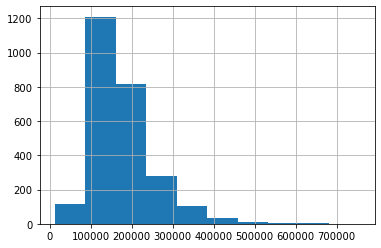

In [186]:
target.hist()

In [ ]:
df_test.

# Modeling

# Correlation Matrix
Correlation tells us how strong the relationship is

backers  usd_pledged_real  usd_goal_real  duration_in_days  \
backers           1.000000          0.754823       0.005271         -0.000972   
usd_pledged_real  0.754823          1.000000       0.006060          0.000806   
usd_goal_real     0.005271          0.006060       1.000000          0.004046   
duration_in_days -0.000972          0.000806       0.004046          1.000000   
percent_pledged   0.016782          0.008661      -0.000468          0.000423   

                  percent_pledged  
backers                  0.016782  
usd_pledged_real         0.008661  
usd_goal_real           -0.000468  
duration_in_days         0.000423  
percent_pledged          1.000000

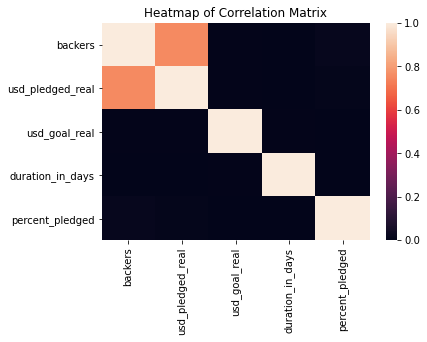

In [569]:
#What features correlate the most with success or other features? 
corr=df_us.corr()
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)
plt.title('Heatmap of Correlation Matrix')
corr

In [ ]:
## There is a high correlation between the number of backers and the amount pledged by the backers/the amount raised

# Find the p-value for the correlation between the number of backers and the amount pledged by the backers/the amount raised

In [570]:
import scipy as sc
from scipy import stats
pearson_coef,p_value=stats.pearsonr(df_us.backers,df_us.usd_pledged_real)
pearson_coef

0.7548234979124591

In [572]:
p_value 
#Since it's less than 0.001, there's a strong certainty in the result

0.0